In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout,SimpleRNN,LSTM,Conv1D,Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
import keras
import sklearn
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('ACdailyS.csv',delimiter=';')
df.head()

,timestamp,appap,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg
0,2013-11-01,920.335194,24,32.4,27.5,79,19.0,5.0,3,160,0
1,2013-11-02,0.000000,25,32.6,28.2,77,0.0,6.8,3,60,0
2,2013-11-03,0.000000,27,33.4,29.2,76,NaN,4.2,3,360,1
3,2013-11-04,1103.977583,26,32.0,28.7,79,NaN,4.5,4,320,1
4,2013-11-05,126.806000,26,33.4,29.3,76,0.0,3.0,5,360,2


In [3]:
df.isnull().sum()

timestamp     0
appap         0
Tn            0
Tx            0
Tavg          0
RH_avg        0
RR           15
ss           14
ff_x          0
ddd_x         0
ff_avg        0
dtype: int64

In [4]:
mode_RR=df['RR'].mode()[0]
mode_ss=df['ss'].mode()[0]
mean_appap=df['appap'].mean()
df['RR'].fillna(value=mode_RR, inplace=True)
df['ss'].fillna(value=mode_ss, inplace=True)
df['appap'].fillna(value=mean_appap, inplace=True)
df.isnull().sum()

timestamp    0
appap        0
Tn           0
Tx           0
Tavg         0
RH_avg       0
RR           0
ss           0
ff_x         0
ddd_x        0
ff_avg       0
dtype: int64

In [5]:
train_dates = pd.to_datetime(df['timestamp'])

In [6]:
df['Day']= pd.DatetimeIndex(df['timestamp']).day_of_week
df['month']=pd.DatetimeIndex(df['timestamp']).month
df['year']=pd.DatetimeIndex(df['timestamp']).year
df['quarter']=pd.DatetimeIndex(df['timestamp']).quarter
df['dayofyear']=pd.DatetimeIndex(df['timestamp']).dayofyear
df['dayofmonth']=pd.DatetimeIndex(df['timestamp']).day
df['weekofyear']=pd.DatetimeIndex(df['timestamp']).weekofyear

<ipython-input-6-85aab07ef984>:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear']=pd.DatetimeIndex(df['timestamp']).weekofyear


In [7]:
pearsoncorr = df.corr(method='pearson', min_periods=7)
pearsoncorr['appap']

appap         1.000000
Tn            0.076154
Tx            0.314729
Tavg          0.342783
RH_avg       -0.280477
RR           -0.165655
ss            0.270747
ff_x         -0.011398
ddd_x        -0.096679
ff_avg       -0.074332
Day          -0.529650
month         0.207942
year         -0.029042
quarter       0.186077
dayofyear     0.201774
dayofmonth   -0.073197
weekofyear    0.230045
Name: appap, dtype: float64

In [8]:
df = df.drop(['RH_avg', 'ff_x', 'ddd_x', 'ff_avg', 'RR', 'year','dayofmonth'], axis=1)
df.head()

,timestamp,appap,Tn,Tx,Tavg,ss,Day,month,quarter,dayofyear,weekofyear
0,2013-11-01,920.335194,24,32.4,27.5,5.0,4,11,4,305,44
1,2013-11-02,0.000000,25,32.6,28.2,6.8,5,11,4,306,44
2,2013-11-03,0.000000,27,33.4,29.2,4.2,6,11,4,307,44
3,2013-11-04,1103.977583,26,32.0,28.7,4.5,0,11,4,308,45
4,2013-11-05,126.806000,26,33.4,29.3,3.0,1,11,4,309,45


In [9]:
cols = list(df)[1]

In [19]:
df_for_training = df[cols].astype(float)
df2=np.array(df_for_training)
df2 = df2.reshape(-1, 1)

In [20]:
scaler = StandardScaler()
scaler = scaler.fit(df2)
df_for_training_scaled = scaler.transform(df2)

In [21]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 7  # Number of past days we want to use to predict the future.

In [23]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df2.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

testX,testY = trainX[-11:],trainY[-11:]
trainX, trainY = trainX[:-11],trainY[:-11]
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (358, 7, 1).
trainY shape == (358, 1).
testX shape == (11, 7, 1).
testY shape == (11, 1).


In [24]:
model = Sequential()
#model.add(Conv1D(filters=128, kernel_size=2,strides=1, padding='causal',activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 206,465
Trainable params: 206,465
Non-trainable params: 0
_________________________________________________________________


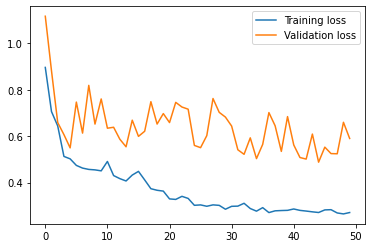

In [25]:
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_data=(testX, testY), verbose=0)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [26]:
n_days_for_prediction=11
prediction = model.predict(testX)

In [27]:
from sklearn.metrics import r2_score,mean_absolute_error
lstm_score = r2_score(testY, prediction)

print("R^2 Score of LSTM model = ",lstm_score)


R^2 Score of LSTM model =  0.507560397436014
mae =  0.5499614641373527


In [28]:
n_past = 11
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
print(predict_period_dates)


[Timestamp('2014-11-01 00:00:00', freq='D'), Timestamp('2014-11-02 00:00:00', freq='D'), Timestamp('2014-11-03 00:00:00', freq='D'), Timestamp('2014-11-04 00:00:00', freq='D'), Timestamp('2014-11-05 00:00:00', freq='D'), Timestamp('2014-11-06 00:00:00', freq='D'), Timestamp('2014-11-07 00:00:00', freq='D'), Timestamp('2014-11-08 00:00:00', freq='D'), Timestamp('2014-11-09 00:00:00', freq='D'), Timestamp('2014-11-10 00:00:00', freq='D'), Timestamp('2014-11-11 00:00:00', freq='D')]


In [30]:
prediction_copies = np.repeat(prediction, df2.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [31]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [32]:
df_forecast = pd.DataFrame({'timestamp':np.array(forecast_dates), 'appap':y_pred_future})
df_forecast['timestamp']=pd.to_datetime(df_forecast['timestamp'])


In [33]:
original = df[['timestamp', 'appap']]
original['timestamp']=df_forecast['timestamp']
original = original.iloc[-11:]


<ipython-input-33-79192af0b5de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['timestamp']=df_forecast['timestamp']


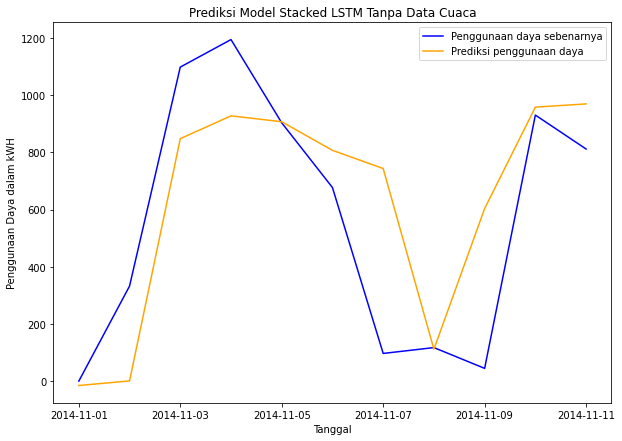

In [42]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(10,7))
    plt.plot(df_forecast['timestamp'],test, color='blue',label='Penggunaan daya sebenarnya')
    plt.plot(df_forecast['timestamp'],predicted, color='orange',label='Prediksi penggunaan daya')
    plt.title(title)
    plt.xlabel('Tanggal')
    plt.ylabel('Penggunaan Daya dalam kWH')
    plt.legend()
    plt.show()
plot_predictions(original['appap'], df_forecast['appap'], "Prediksi Model Stacked LSTM Tanpa Data Cuaca")

In [39]:
def calculate_smape(actual, predicted) -> float:
  
    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)
  
    return round(
        np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2
    )

In [36]:
calculate_smape(original['appap'], df_forecast['appap'])

74.55

In [37]:
model.save("model_StackedLSTM_usageonly.h5")

In [43]:
mae = mean_absolute_error(original['appap'], df_forecast['appap'])
print("mae = ",mae)

mae =  217.67891877915156
